In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime

2024-05-13 13:45:33.473661: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 13:45:33.525587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 13:45:33.525622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 13:45:33.526661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 13:45:33.534180: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed=360
num_components=4
learning_rate = 0.05
epochs=200
outdir = '/cluster/home/kheuto01/testdir'
penalty = 5000
threshold = 0.55
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500
perturbed_sigma=0.1
num_score_func_samples=25
batch_size=300

In [3]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed, batch_size=batch_size)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)
input_shape = (H,S)

bpr_K = get_perturbed_bpr_func(K, sigma=perturbed_sigma)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


2024-05-13 13:47:23.298419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-13 13:47:23.298460: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-05-13 13:47:23.298467: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-05-13 13:47:23.298576: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-13 13:47:23.298605: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-13 13:47:23.298610: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [4]:
model  = get_mixture(location_specific_linear, input_shape, num_components=num_components)

In [5]:
for index in [0, 2, 4, 6]:
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))

Name: linear_convolution/kernel:0
Shape: (1, 3, 1)
Name: linear_convolution/kernel:0
Shape: (1, 3, 1)
Name: linear_convolution/kernel:0
Shape: (1, 3, 1)
Name: linear_convolution/kernel:0
Shape: (1, 3, 1)


In [6]:
for index, bias in zip([1, 3, 5, 7], [0.0+1e-13, 7.0, 10.0, 100.0]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))

Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)
Name: linear_convolution/bias:0
Shape: (1,)


In [7]:
index = -1
variable = model.trainable_variables[index]
print(f'Name: {variable.name}')
print(f'Shape: {variable.shape}')

# equal to 0
component_1 = np.array([0,0,0,0, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9], dtype=np.float32).T
# equal to 7
component_2 = np.array([1,1,1,1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32).T
# equal to 10
component_3 = np.array([0,0,0,0, 0.7, 0.7, 0.7, 0.7, 0, 0, 0, 0], dtype=np.float32).T
# equal to 10
component_4 = np.array([0,0,0,0, 0,0,0,0, 0.1, 0.1, 0.1, 0.1], dtype=np.float32).T

# make components columns of new weight matrix
weights = np.stack([component_1, component_2, component_3, component_4], axis=1)

variable.assign(tf.math.log(weights+1e-13))

Name: shared_mix_weights:0
Shape: (12, 4)


<tf.Variable 'UnreadVariable' shape=(12, 4) dtype=float32, numpy=
array([[-29.933605  ,   0.        , -29.933605  , -29.933605  ],
       [-29.933605  ,   0.        , -29.933605  , -29.933605  ],
       [-29.933605  ,   0.        , -29.933605  , -29.933605  ],
       [-29.933605  ,   0.        , -29.933605  , -29.933605  ],
       [ -1.2039728 , -29.933605  ,  -0.35667497, -29.933605  ],
       [ -1.2039728 , -29.933605  ,  -0.35667497, -29.933605  ],
       [ -1.2039728 , -29.933605  ,  -0.35667497, -29.933605  ],
       [ -1.2039728 , -29.933605  ,  -0.35667497, -29.933605  ],
       [ -0.10536054, -29.933605  , -29.933605  ,  -2.3025851 ],
       [ -0.10536054, -29.933605  , -29.933605  ,  -2.3025851 ],
       [ -0.10536054, -29.933605  , -29.933605  ,  -2.3025851 ],
       [ -0.10536054, -29.933605  , -29.933605  ,  -2.3025851 ]],
      dtype=float32)>

In [8]:
model.variables

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([-29.933607], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([6.999088], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([9.999954], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([100.],

In [8]:
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)

In [9]:
@tf.function
def get_sample_log_probs(mixture, num_score_func_samples):
    # todo concretize this
    sample_y_MBS = mixture.sample(num_score_func_samples)+1e-9
    sample_log_probs_MBS = mixture.log_prob(sample_y_MBS)

    return sample_y_MBS, sample_log_probs_MBS

@tf.function
def get_expected_decisions(sample_y_MBS):
    sample_decisions_MBS = cross_ratio_decision(sample_y_MBS)
    expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

    return sample_decisions_MBS, expected_decisions_BS

@tf.function
def get_loss(mixture, y_BS, expected_decisions_BS, bpr_K):
    bpr_B = bpr_K(y_BS, expected_decisions_BS)
    observed_log_prob_BS = mixture.log_prob(y_BS)

    loss_B = -tf.reduce_sum(observed_log_prob_BS, axis=-1)
    violate_threshold_flag_B = tf.cast(tf.greater(threshold,
                                                bpr_B),
                                        tf.float32)
    loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)
    return observed_log_prob_BS, bpr_B, loss_B


In [10]:
# just 50 rows
example_X = train_X_THS[:50]
example_y = train_y_TS[:50]
example_X.shape

(50, 3, 12)

In [11]:
gradient_magnitudes = []
param_vals = []
# test 20 evenly spaced points between 5 and 9, with one point at 7 
for param_value in np.linspace(5, 9, 20, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[3]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([param_value]))

    for sample in range(10):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
            mixture = model(example_X, training=True)
            sample_y_MBS, sample_log_probs_MBS = get_sample_log_probs(mixture, num_score_func_samples)
            sample_decisions_MBS, expected_decisions_BS = get_expected_decisions(sample_y_MBS)
            observed_log_prob_BS, bpr_B, loss_B = get_loss(mixture, example_y, expected_decisions_BS, bpr_K)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)

        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        param_vals.append(param_value)
        gradient_magnitudes.append(overall_gradient[3])




5.0
Name: linear_convolution/bias:0
Shape: (1,)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5.2105265
Name: linear_convolution/bias:0
Shape: (1,)
5.4210525
Name: linear_convolution/bias:0
Shape: (1,)
5.631579
Name: linear_convolution/bias:0
Shape: (1,)
5.8421054
Name: linear_convolution/bias:0
Shape: (1,)
6.0526314
Name: linear_convolut

In [ ]:
plt.plot(param_vals, gradient_magnitudes,'k.')

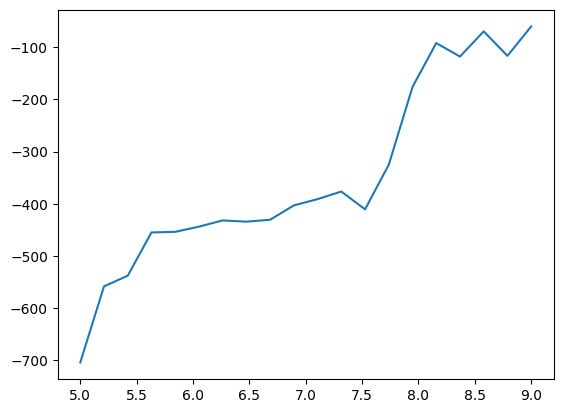

In [16]:
plt.plot(param_vals, gradient_magnitudes,'k.')

In [13]:
# print array formatted to 3 decimal places
print(f'Expected decisions: {expected_decisions_BS.numpy()[0].round(3)}')
# print index of top 4 decisions:
print(f'Top 4 decisions: {tf.argsort(expected_decisions_BS, direction="DESCENDING")[:4].numpy()}')

Expected decisions: [0.094 0.114 0.116 0.105 0.072 0.078 0.074 0.07  0.124 0.1   0.    0.053]
Top 4 decisions: [[ 8  2  1  3  9  0  5  6  4  7 11 10]
 [ 1  2  3  0  7  4  9  5 11  6 10  8]
 [ 0 11  1  3  2  4  7  5  6  8 10  9]
 [ 3  0  1  2  7  6  4  5  8 10  9 11]]


In [14]:
[overall_gradient[bias] for bias in [1,3,5,7]]

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-9.2464585e-11], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-60.58092], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([337.75378], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([107.6995], dtype=float32)>]

In [15]:
overall_gradient

[<tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[ 3.2522249e-11],
         [ 3.2530683e-11],
         [-9.2465008e-10]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-9.2464585e-11], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[-424.0662],
         [-424.0662],
         [-424.0662]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-60.58092], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[2001.1088],
         [3619.3289],
         [3372.536 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([337.75378], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[-2255.1584],
         [-5333.6167],
         [-2615.193 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([107.6995], dtype=float32)>,
 <tf.Tensor: shape=(12, 4), dtype=float32, numpy=
 array([[ 2.5001456e-11, -4.4690217e-11, -5.3126800e

In [53]:
train_X_THS.shape

(300, 3, 12)

In [17]:
gradient_magnitudes

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-703.89185], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-558.1494], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-537.78644], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-454.94662], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-453.7578], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-443.86987], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-431.9073], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-434.29083], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-430.63348], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-403.13583], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-391.11728], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-376.63925], dtype=float32)>,
 <tf.Te